In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [2]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated")
df=data_df.loc[2:140,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd","churn","temp_deviation"]] 
print(df)

#start at 15 for churn
#first ets value at line 38

     months  price_gas  price_brent_gbp  open_interest_gas       lng  \
2    Dec 09  38.318182        52.288674            12590.0  1.670000   
3    Jan 10  44.157175        54.302797            13650.0  1.540000   
4    Feb 10  35.532880        55.081704            12720.0  1.330000   
5    Mar 10  33.494927        58.531509            18530.0  1.320000   
6    Apr 10  37.141256        62.149675            19305.0  1.720000   
..      ...        ...              ...                ...       ...   
136  Feb 21  36.471127        40.980074            41235.0  1.897236   
137  Mar 21  42.778793        43.494060            44325.0  2.321223   
138  Apr 21  54.713896        42.188306            37515.0  2.111904   
139  May 21  54.765343        43.616761            35298.0  1.428956   
140  Jun 21  77.151842        47.484969            35409.0  1.016736   

      storage  temperature     euas     supply   coal_gbp   eurgbp    gbpusd  \
2    0.660000         4.15  10.6420  10.660000  58.7071

In [3]:
#Vector:
dprice_gas=df.price_gas
dprice_brent_gbp=df.price_brent_gbp
dOI=df.open_interest_gas
dtemp=df.temperature
dtempdev=df.temp_deviation
dstore=df.storage
dlng=df.lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dUSD=df.gbpusd
dcoal=df.coal_gbp
dchurn=df.churn

time= df.months
DataSeries=[dtempdev, dstore, dlng, dprice_brent_gbp, dprice_gas, dcoal]
#DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp, dtempdev]

#DataSeries=[dprice_gas,dprice_brent_gbp,dOI,dstore,dlng,dtemp,dsupply,dEUAs,dchurn,dtempdev,dEUR,dUSD,dcoal]
df_test = pd.concat(DataSeries,axis=1)

In [4]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-7.844900,0.000000,0.000000
storage,-2.275218,0.180085,11.000000
lng,-2.895856,0.045832,3.000000
price_brent_gbp,-1.564309,0.501493,2.000000
price_gas,-2.215659,0.200611,4.000000
coal_gbp,-1.901091,0.331548,2.000000


In [5]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.512136,0.038933,4.000000
storage,0.148617,0.100000,5.000000
lng,0.516955,0.037848,5.000000
price_brent_gbp,1.194108,0.010000,6.000000
price_gas,0.775947,0.010000,6.000000
coal_gbp,0.601696,0.022482,6.000000


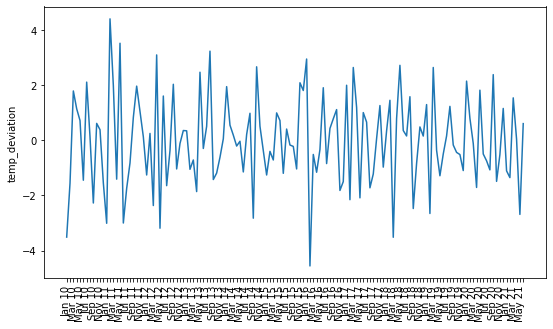

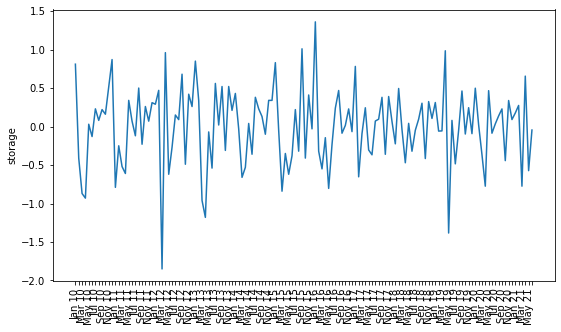

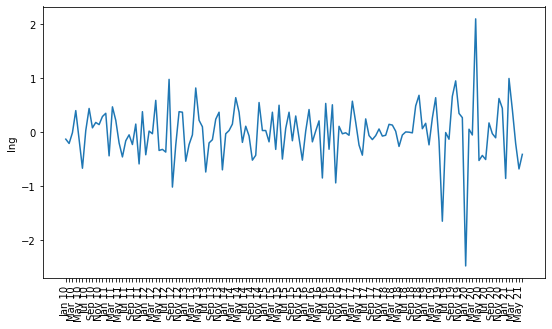

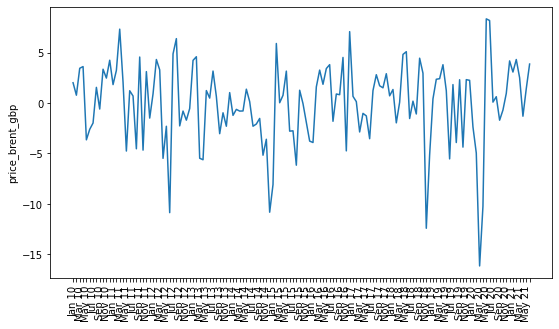

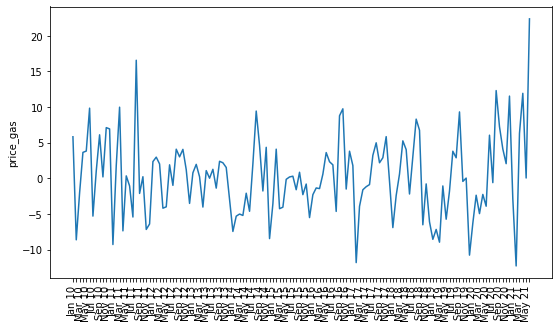

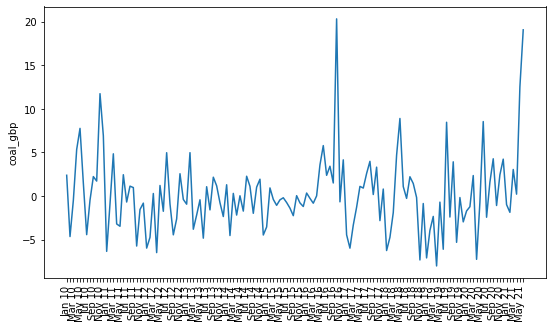

In [6]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### initiate corrected series
DataSeriesCorr=[]

#### select correction mode
TypeCorr = 'diff' # 'HP' for filtering or 'log' or 'bothHPlog'

for df in DataSeries:

    if TypeCorr == "log" or TypeCorr == 'bothHPlog':
            df_log = pd.Series(np.log(df))
            df = df_log

    if TypeCorr == 'HP' or TypeCorr == 'bothHPlog':
        cycle, trend = sm.tsa.filters.hpfilter(df, 129600)
        plt.plot(trend)
        plt.plot(cycle)
        cycle.name = df.name
        df = cycle

    if TypeCorr == 'diff':
        df_diff = df.diff().dropna()
        df = df_diff

    plt.figure(figsize=(9, 5))
    if TypeCorr == 'diff':        
        plt.plot(time.iloc[1:], df)
    else: 
        plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)




df_corr = pd.concat(DataSeriesCorr,axis=1)




In [7]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-9.576254,0.000000,5.000000
storage,-8.355464,0.000000,11.000000
lng,-8.108766,0.000000,4.000000
price_brent_gbp,-7.559910,0.000000,2.000000
price_gas,-5.524237,0.000002,3.000000
coal_gbp,-5.639243,0.000001,1.000000


In [8]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.114884,0.100000,22.000000
storage,0.015378,0.100000,1.000000
lng,0.045887,0.100000,6.000000
price_brent_gbp,0.108511,0.100000,0.000000
price_gas,0.116198,0.100000,2.000000
coal_gbp,0.146910,0.100000,3.000000


In [9]:
#### EXPORT NORMALISED DATA ####


df_export = df_corr

#df_export.insert(0,'months',time)
#print(df_export)
#df_export.to_excel(r'export_normal_data.xlsx', index = False)

#df_corr.drop(columns=['months'])
#print(df_corr)

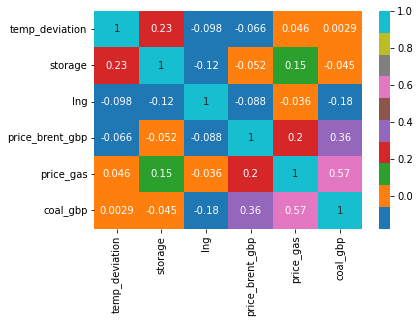

In [10]:
#### CORRELATION MATRIX ####

CorrelationMatrix=df_corr.corr()
ax=sns.heatmap(CorrelationMatrix, annot=True, cmap="tab10")


     temp_deviation   storage       lng  price_brent_gbp  price_gas   coal_gbp
3         -3.506667  0.810000 -0.130000         2.014124   5.838994   2.389752
4         -1.551667 -0.410000 -0.210000         0.778906  -8.624296  -4.633471
5          1.786667 -0.870000 -0.010000         3.449805  -2.037953  -0.478690
6          1.141667 -0.930000  0.400000         3.618166   3.646329   5.344300
7          0.715000  0.030000 -0.130000        -3.648643   3.831899   7.763045
..              ...       ...       ...              ...        ...        ...
136       -1.351667  0.274075  0.996634         4.318999 -12.290340  -1.856367
137        1.536667 -0.774803  0.423987         2.513986   6.307666   3.052882
138        0.041667  0.655010 -0.209319        -1.305754  11.935103   0.224162
139       -2.685000 -0.572943 -0.682949         1.428455   0.051447  12.514718
140        0.603333 -0.045336 -0.412220         3.868208  22.386499  19.055279

[138 rows x 6 columns]


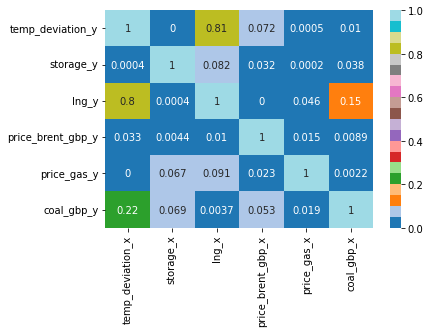

In [11]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
print(df_corr)
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


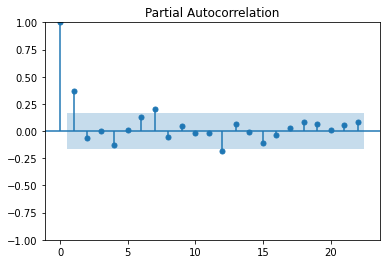

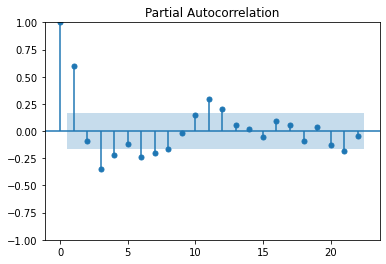

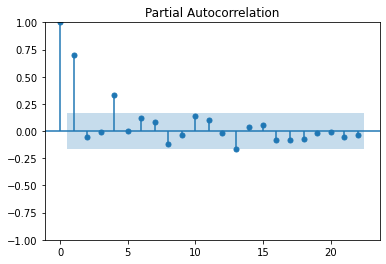

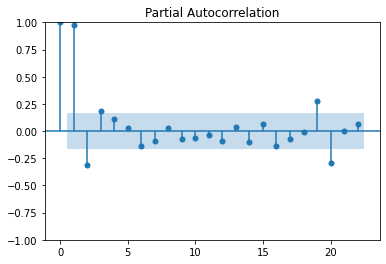

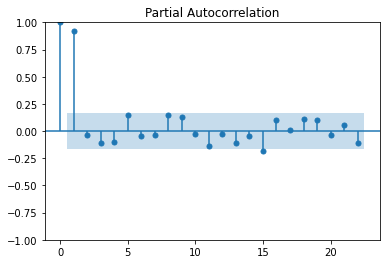

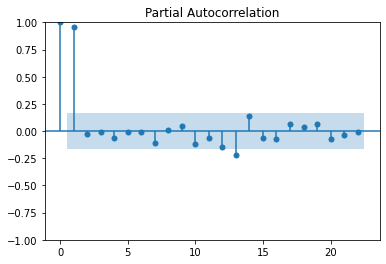

In [12]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [13]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,6.658,6.794*,779.1,6.713*
1,6.465,7.416,643.0,6.852
2,6.436,8.201,627.0,7.153
3,6.063,8.642,435.7*,7.111
4,6.068,9.462,446.4,7.447
5,6.216,10.42,533.6,7.926
6,6.403,11.43,673.5,8.444
7,6.568,12.41,848.2,8.939
8,6.647,13.30,1005.,9.349
9,6.596,14.06,1078.,9.630


In [14]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(6)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 28, Jul, 2022
Time:                     23:20:52
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    11.3912
Nobs:                     132.000    HQIC:                   8.51301
Log likelihood:          -1333.63    FPE:                    761.553
AIC:                      6.54287    Det(Omega_mle):         172.911
--------------------------------------------------------------------
Results for equation temp_deviation
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.003423         0.115300            0.030           0.976
L1.temp_deviation         -0.354204         0.108233           -3.273           0.001
L1.storage                -1.15

True


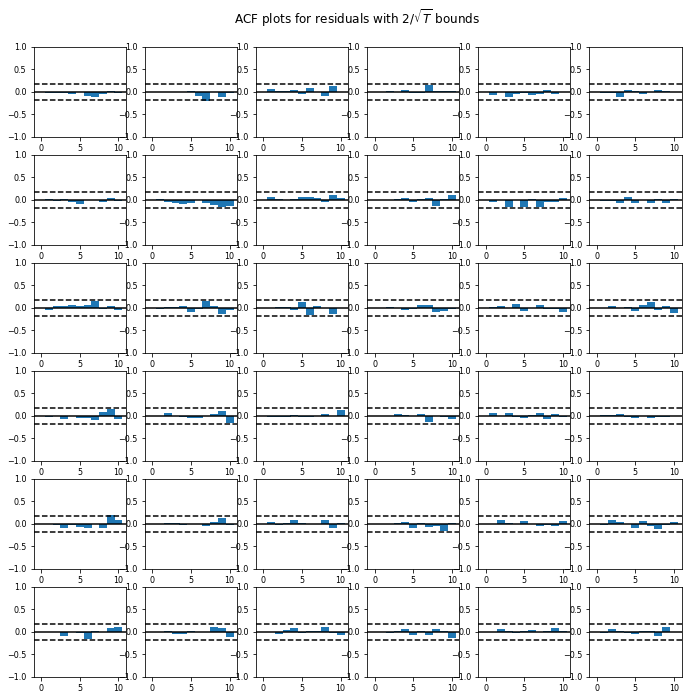

In [15]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
accor = model_fit.plot_acorr()

stab = model_fit.is_stable()
print(stab)

#if residuals out of range -> unstable model 

In [16]:
######### GRANGER CAUSALITY TEST #########
#for gas price
GrangerCausality = model_fit.test_causality('price_gas', ['lng'], kind='f')
print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

Granger causality F-test. H_0: lng does not Granger-cause price_gas. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.484          2.114   0.181 (6, 570)
----------------------------------------------


In [17]:
######### NORMALITY TEST #########

TestNorm = model_fit.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         60.20          21.03   0.000 12
----------------------------------------


In [18]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = model_fit.test_whiteness(nlags=18)
print(TestWhite.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 18 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         428.4          481.5   0.540 432
-----------------------------------------


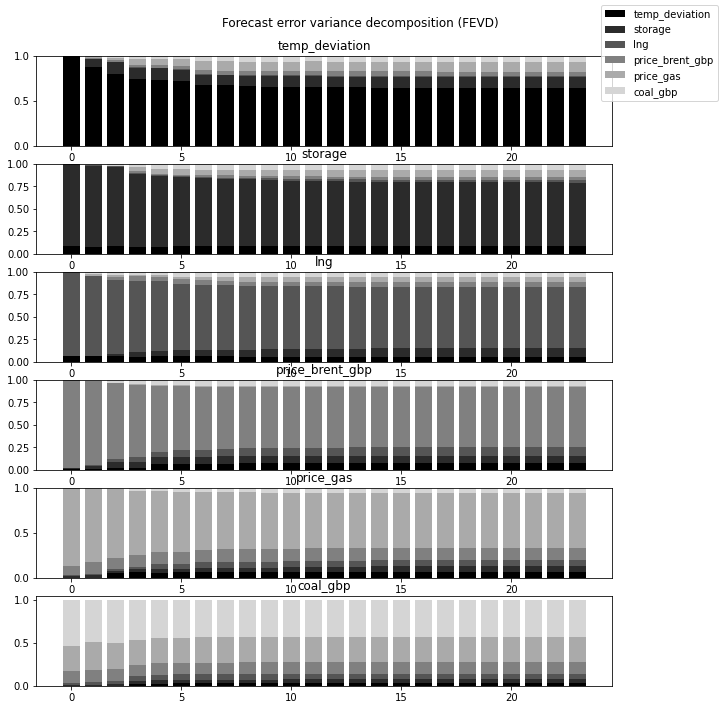

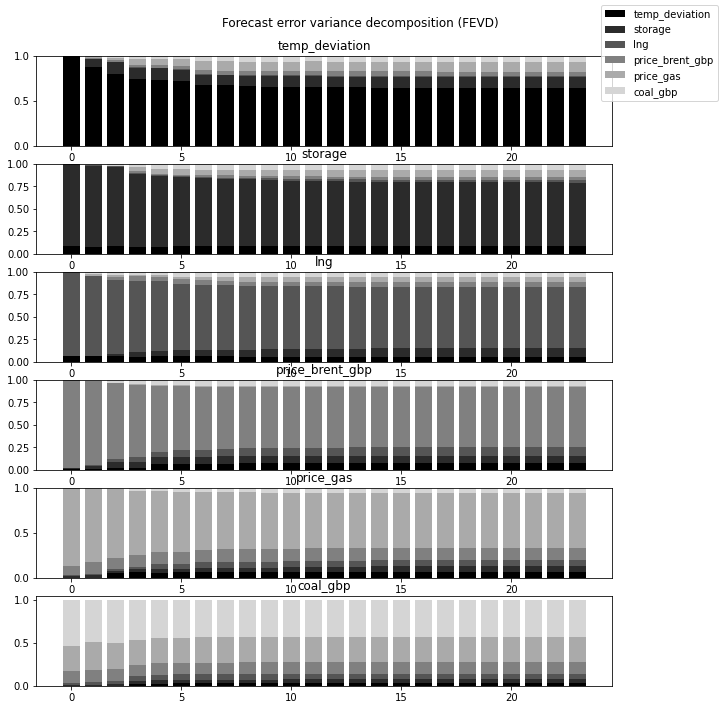

In [19]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=24
VD = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
VD.plot()

IMPULSE RESPONSE ANALYSIS:

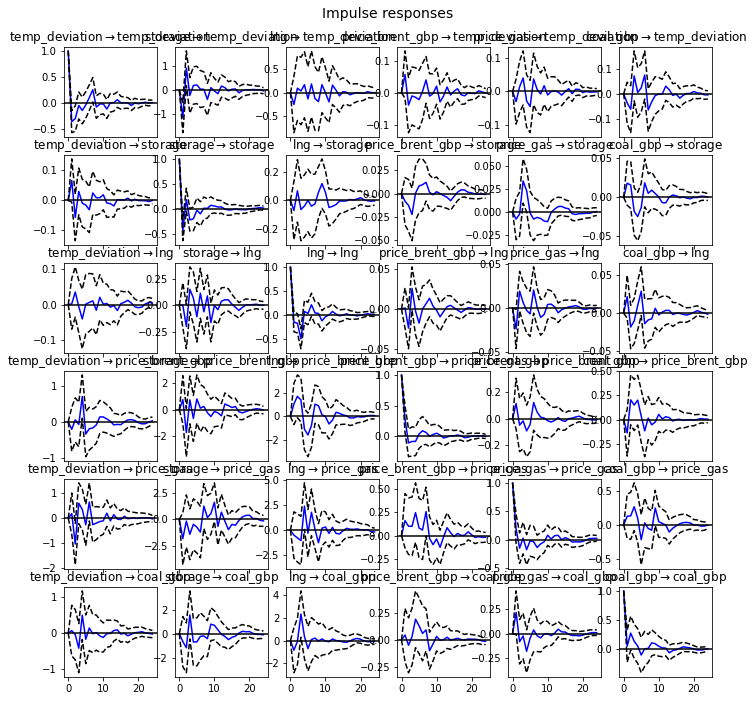

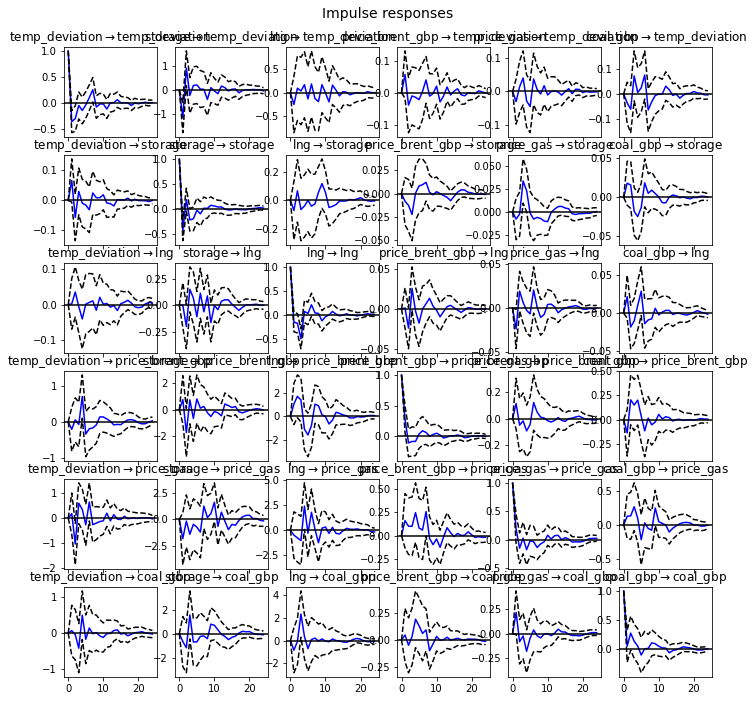

In [20]:
Impulse = model_fit.irf(24)

Impulse.plot()

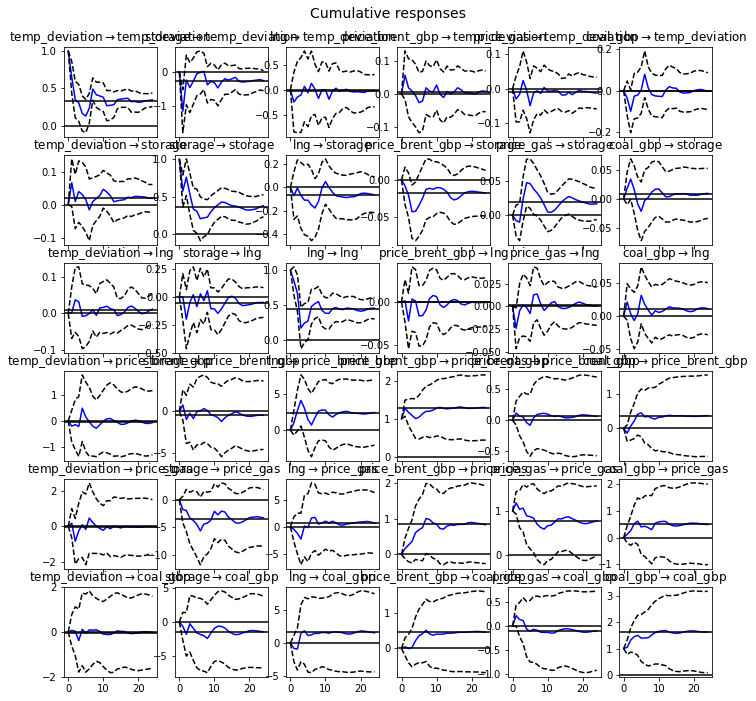

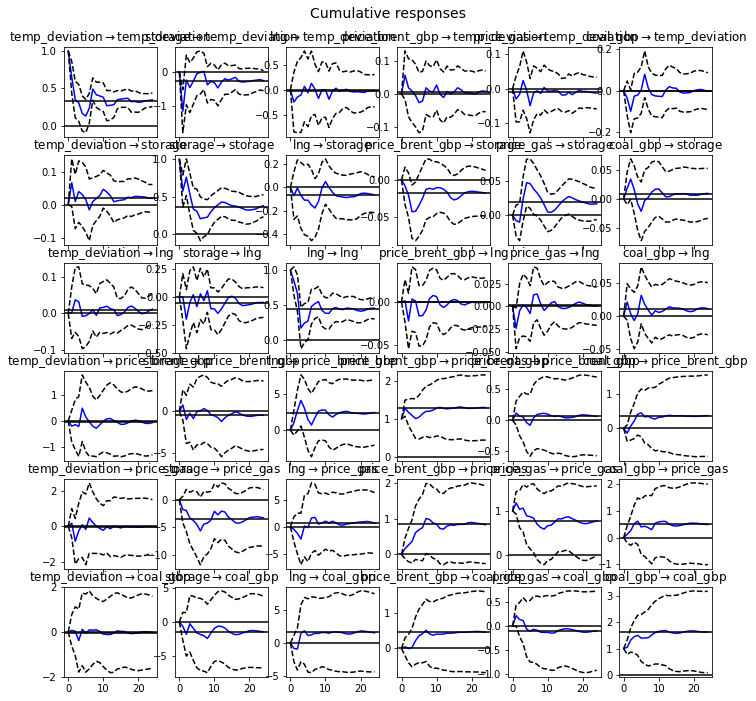

In [21]:
Impulse.plot_cum_effects(orth=False)

OTHER MODELS

In [22]:
from statsmodels.tsa.api import SVAR

lag_order =6

#A = np.asarray([[0, 0, 0],['E', 0, 0],[0, 'E', 0]])
#B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])

A = np.asarray([[1, 0, 0, 0, 0, 0], ['E', 1, 0, 0, 'E', 0],['E', 0, 1, 0, 'E', 0],[0, 0, 0, 1, 'E', 0],['E', 'E', 'E', 'E', 1, 'E'],['E', 0, 0, 0, 'E', 1]])
B = np.asarray([['E', 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0],[0, 0, 0, 'E', 0, 0],[0, 0, 0, 0, 'E', 0],[0, 0, 0, 0, 0, 'E']])

StructModel = SVAR(df_corr,svar_type='AB',A=A, B=B)

ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=10000, maxfun=10000, solver='bfgs')



/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
##### IS STABLE ? #####
Stab = ResSVAR.is_stable()
print("SVAR model is stable ? :   ",Stab)

SVAR model is stable ? :    True


In [24]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = ResSVAR.test_whiteness(nlags=10)
print(TestWhite.summary())

#Portmanteau test

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         176.1          173.0   0.036 144
-----------------------------------------


In [25]:
######### NORMALITY TEST #########

TestNorm = ResSVAR.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         60.20          21.03   0.000 12
----------------------------------------


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Pyt

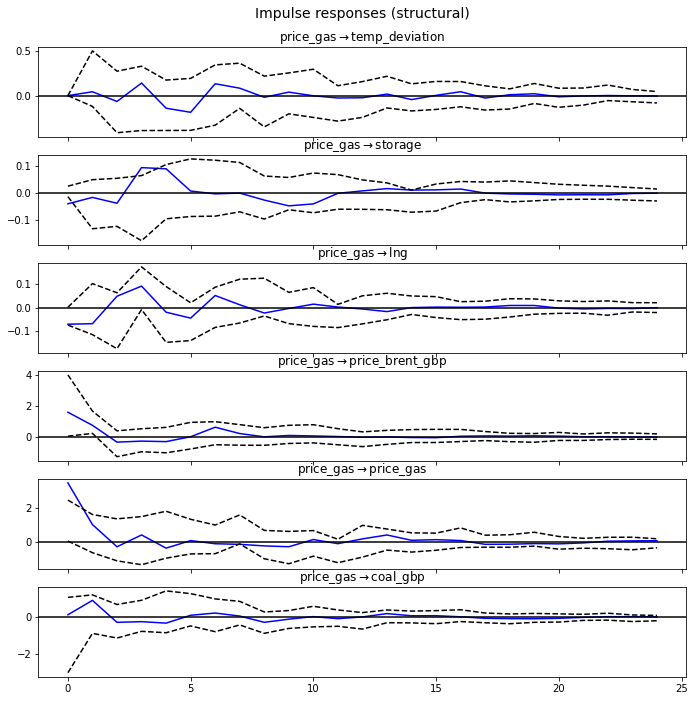

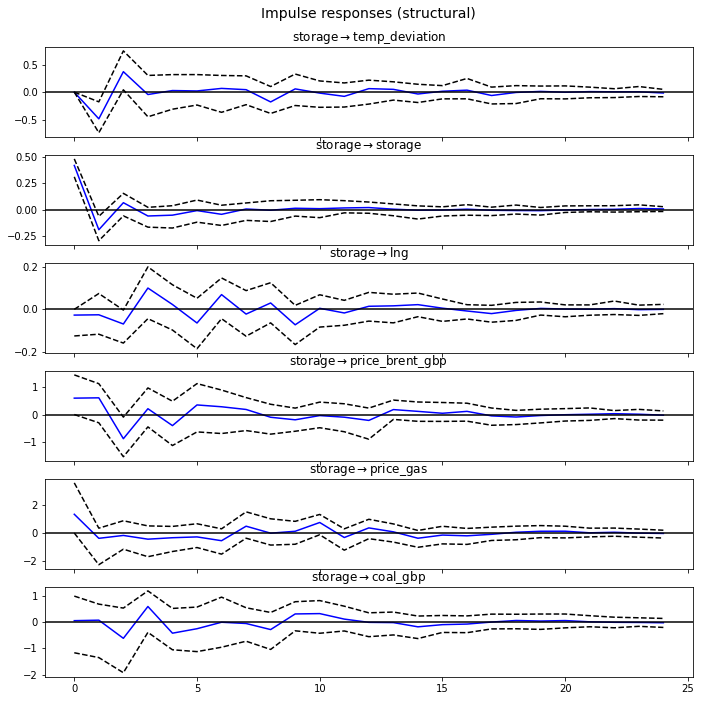

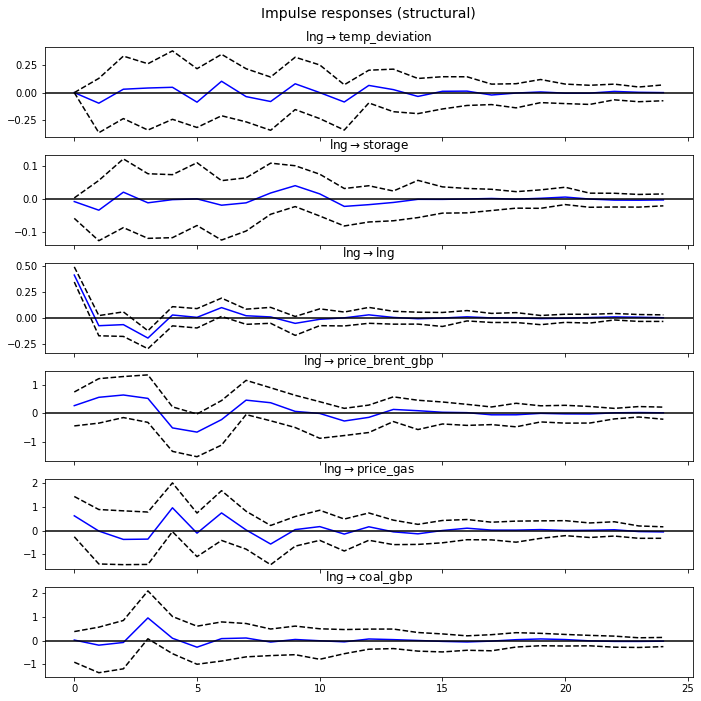

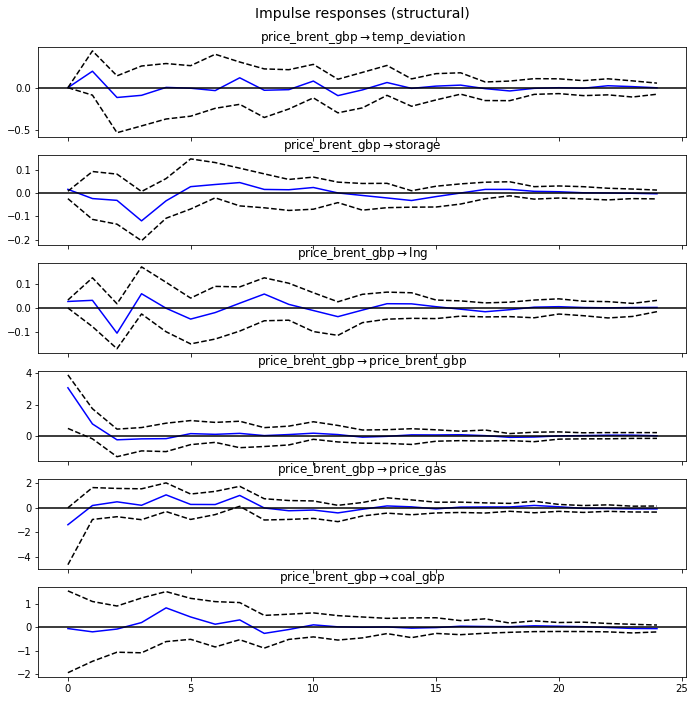

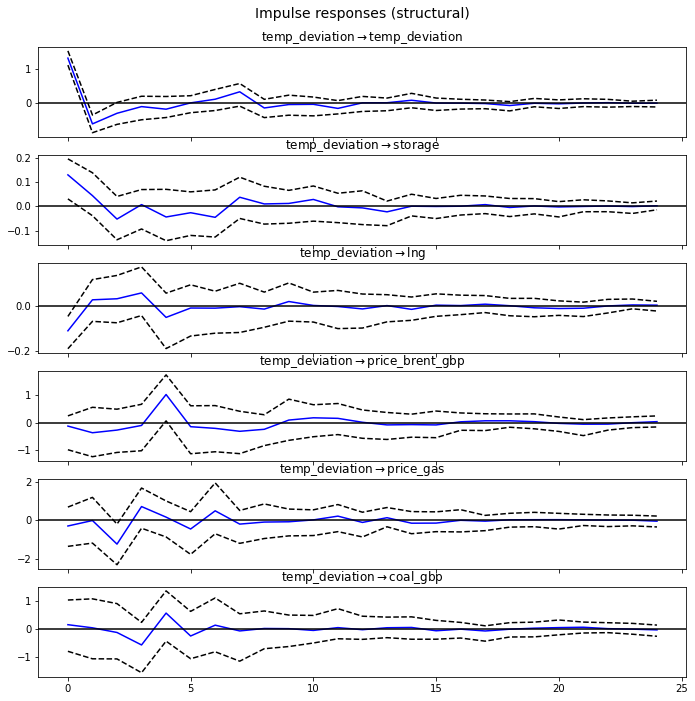

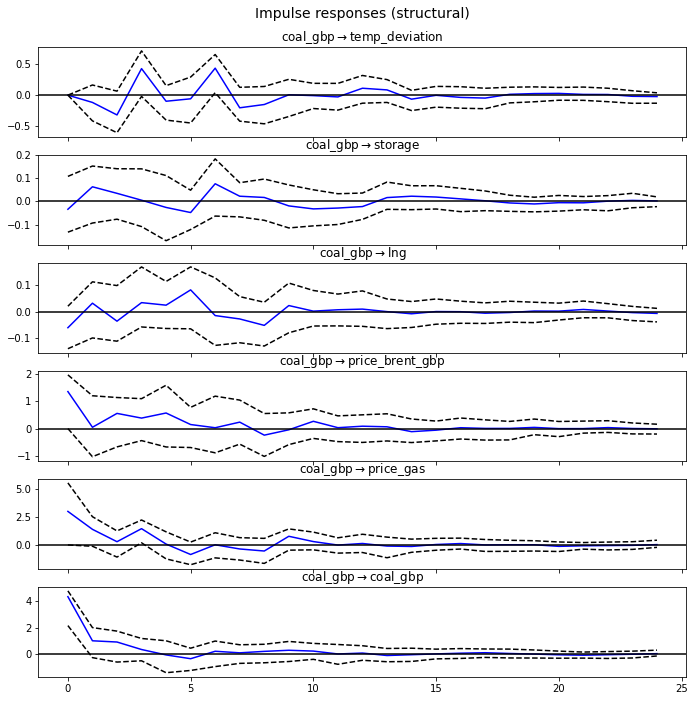

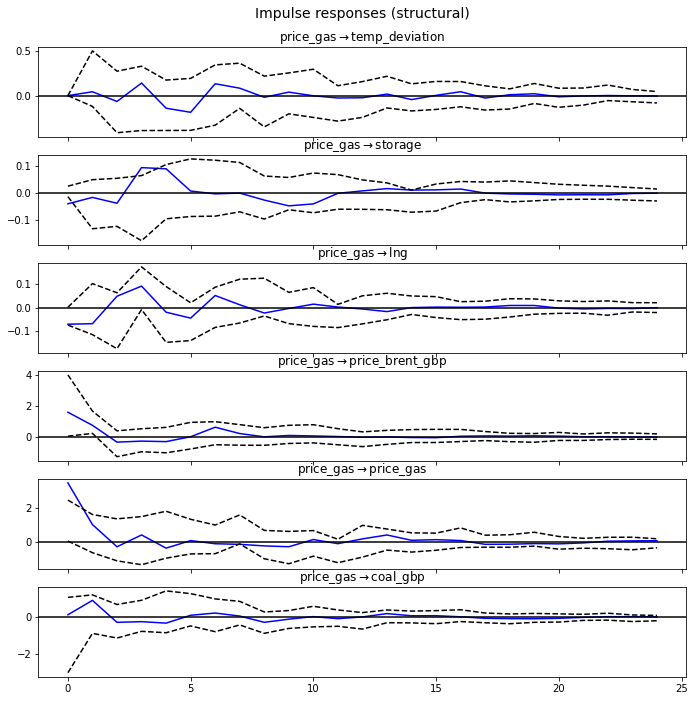

In [29]:
#### IR ####


ResSVAR.irf(periods=24).plot(impulse=['storage','lng'], plot_stderr=True,stderr_type='mc', repl=100)
#ResSVAR.irf(periods=24).plot(impulse='lng', plot_stderr=True,stderr_type='mc', repl=100)
#ResSVAR.irf(periods=24).plot(impulse='price_brent_gbp', plot_stderr=True,stderr_type='mc', repl=100)
#ResSVAR.irf(periods=24).plot(impulse='temp_deviation', plot_stderr=True,stderr_type='mc', repl=100)
#ResSVAR.irf(periods=24).plot(impulse='coal_gbp', plot_stderr=True,stderr_type='mc', repl=100)
#ResSVAR.irf(periods=24).plot(impulse='price_gas', plot_stderr=True,stderr_type='mc', repl=100)




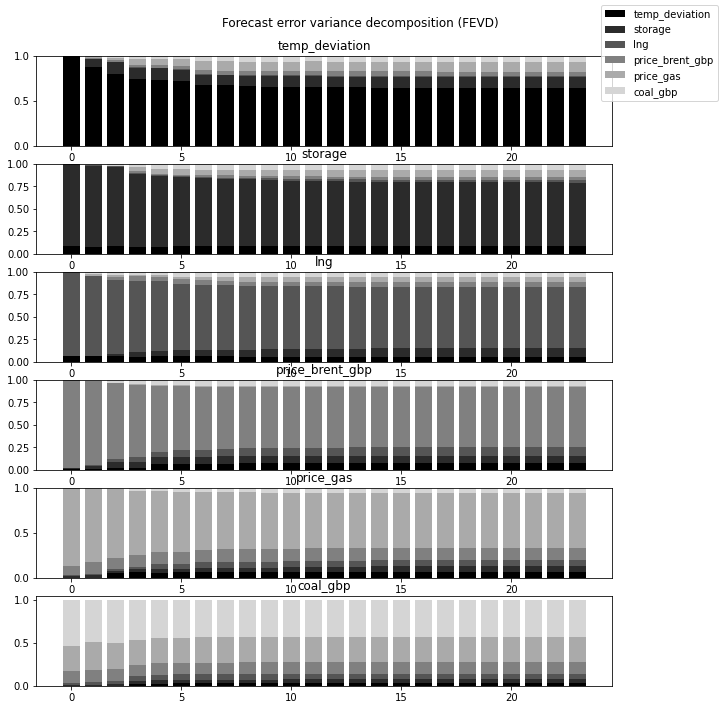

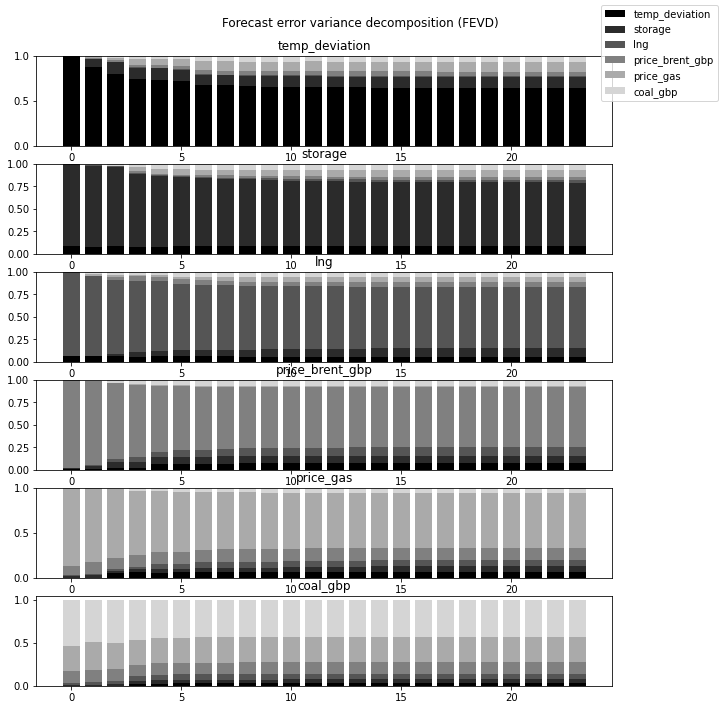

In [30]:
#### FEVD ####


#only for 20 periods
n=24
fevd = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
model_fit.fevd(n).plot()

[[ -1.09666667  -0.0925132    0.269894     2.25282226 -10.77419355
   -2.95085358]
 [  2.14333333   0.4980612   -2.4841485   -2.36605879  -6.28844008
   -1.69930103]
 [  0.79833333   0.0224526    0.054455    -4.95985518  -2.36592083
   -1.21496265]
 [ -0.11333333  -0.3646042   -0.0525444  -16.15865382  -4.94475138
    2.35638029]
 [ -1.70833333  -0.7748028    2.1034365  -10.24168647  -2.25342227
   -7.24385307]
 [  1.815        0.4660707   -0.5262577    8.35160465  -3.9078341
   -0.70616482]
 [ -0.49666667  -0.0865884   -0.4323293    8.18661481   6.05996724
    8.54343739]
 [ -0.74333333   0.034389    -0.5084055    0.09201253  -0.60007123
   -2.42009324]
 [ -1.07166667   0.1377744    0.1716134    0.63093671  12.32198652
    1.60295372]
 [  2.37833333   0.2290082   -0.0274252   -1.70066076   7.25638195
    4.27846329]
 [ -1.48833333  -0.4428011   -0.1047487   -0.69525944   4.12465628
   -1.07354158]
 [ -0.51666667   0.3380284    0.6249219    0.95564107   2.06251331
    2.444062  ]
 [  1

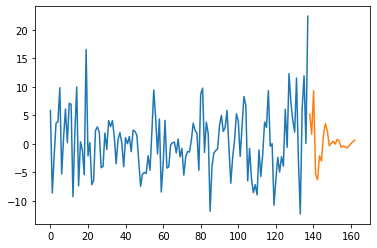

In [31]:
#### Forecast ####

#from fractions import Fraction


from numpy import linspace


yarray=df_corr.to_numpy()
#print(y)
y=yarray[119:,:]
print(y)
print(y.size)
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"

steps = 24
ForecastSVAR = ResSVAR.forecast(y,steps)

print(ForecastSVAR)
ForecastPriceGas = ForecastSVAR[:,4]

serie=yarray[:,4]
print(serie.size)
len=serie.size
xserie = np.linspace(0,len-1,len)
xforecast = np.linspace(len,len+steps,steps)

print(xserie.size)
print(xforecast.size)


print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()


162
[38.31818182 29.69388624 27.65593314 31.30226202 35.13416078 44.98782206
 39.69292131 40.74229818 46.85588393 47.06100642 54.18315481 61.12372572
 51.83899109 53.65013685 63.64039904 56.27474033 56.62353319 55.5650793
 50.14171382 66.71964181 64.60592167 64.8382551  57.67052016 51.26931346
 53.62189437 56.60054375 58.62641522 54.44225642 50.44880621 52.34948809
 51.36811939 55.46173483 58.48224994 62.552759   63.77005992 60.25731789
 61.04051208 63.0055872  63.22318787 59.19661171 60.28283383 60.30546217
 61.57707966 60.20963864 62.60702055 64.79672791 66.32834513 63.34775341
 55.89838016 50.59316722 45.58527924 40.38478264 38.30100642 33.6819645
 35.71255797 45.15901041 49.78413703 48.01558809 52.37279463 43.92124618
 40.3442894  44.44241345 40.18909067 36.1429884  36.00915827 36.2069146
 36.51100642 34.91873324 35.77777289 33.49301041 32.69540323 27.1919137
 24.90472501 23.55980401 22.12507828 22.71390063 26.33232116 28.66398853
 30.56259688 25.92512931 34.71491344 44.47721195 42

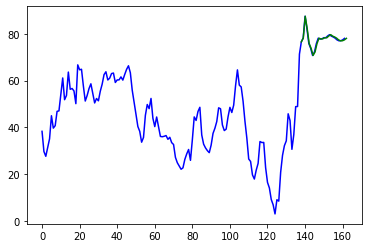

In [32]:
#### DIFF INV ####
diff_total = np.concatenate((yarray[:,4], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,4].size + steps
print(length_set)
PriceReal = np.linspace(0,length_set,length_set)
PriceReal[0] = dprice_gas.values[0]

for i in range(1,length_set):
    PriceReal[i] = diff_total[i] + PriceReal[i-1]

print(PriceReal)
forecasted = PriceReal[-steps:]
print(forecasted)
print(PriceReal.size)

plt.plot(PriceReal, color='blue')
plt.plot(xforecast,forecasted,color="green")
plt.show()


(array([[-1.28528186e-01,  5.94832779e-01, -1.30759263e-01,
         3.31983380e+00,  5.21468761e+00,  6.67515052e+00],
       [-8.77129879e-01,  3.36359556e-01,  1.11294813e-01,
        -1.67325375e+00,  1.65661972e+00,  8.81855898e-01],
       [ 2.26710068e+00,  7.21473579e-02,  4.96250116e-01,
         2.24406632e+00,  9.30936799e+00,  4.63773821e-01],
       [-4.63286619e-01, -1.54714823e-01,  7.84888342e-01,
         3.78874635e+00, -5.34877048e+00, -2.90592435e+00],
       [ 7.67062398e-02,  7.27252276e-02, -3.04103059e-02,
         1.35199684e+00, -6.29459994e+00, -5.74350241e-01],
       [ 1.21243081e+00,  3.83276640e-01, -2.22385038e-01,
         1.94606629e+00, -2.09861000e+00,  8.23232627e-01],
       [-1.37140078e+00, -6.46334560e-03, -5.08094573e-01,
         5.22065891e-01, -3.01145463e+00,  1.26983830e+00],
       [-6.07043481e-01, -1.63024686e-01, -1.04575112e-01,
        -2.51815719e+00,  1.50542822e+00,  1.38308943e+00],
       [ 3.29124582e-01, -3.51801556e-01,  2.51

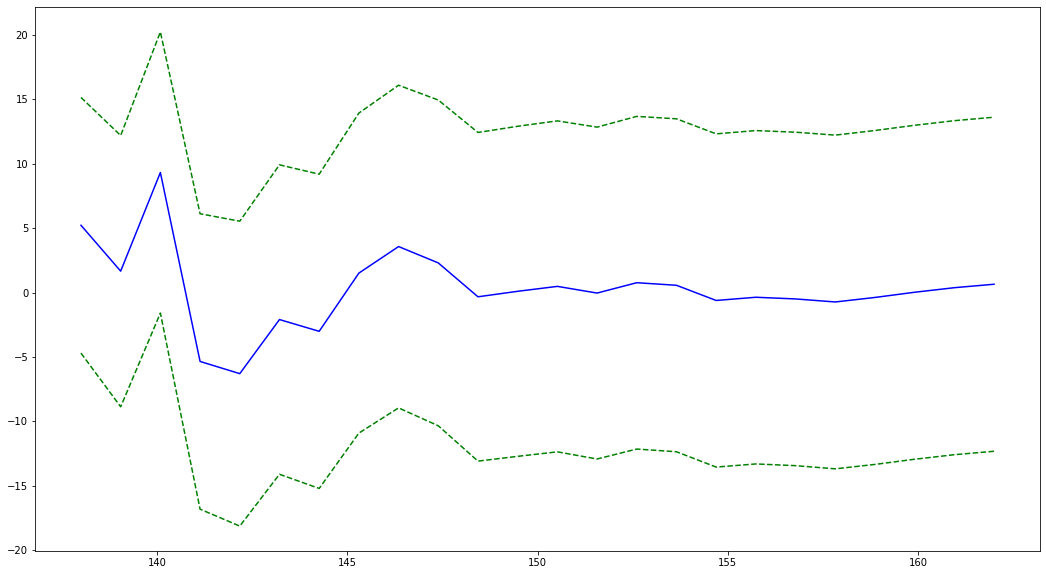

[  77.15184187   68.28646019   66.69067468   49.88377607   31.76371399
   17.66318048    2.46375407   -8.44308735  -17.3941616   -27.73300545
  -40.81361197  -53.52265527  -65.88452207  -78.79959863  -90.94351301
 -103.29690816 -116.83943992 -130.13827925 -143.57167694 -157.24997528
 -170.58582114 -183.51938683 -196.101063   -208.41707709]


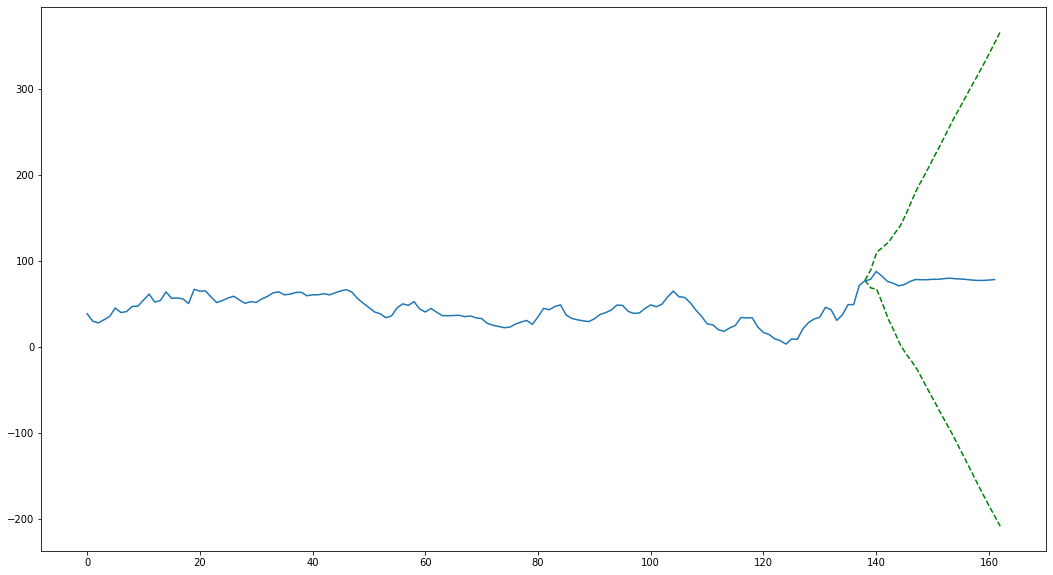

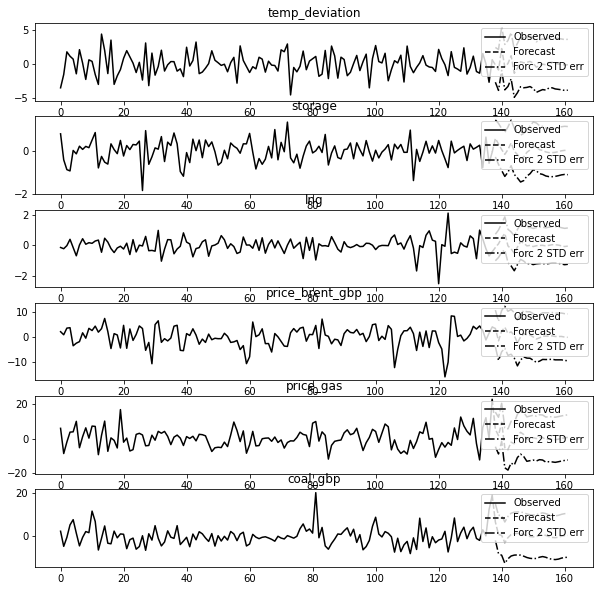

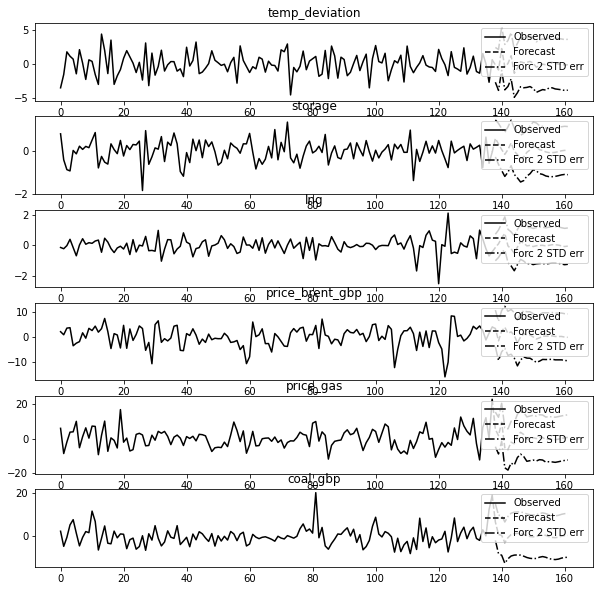

In [33]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)

# diff
UpBandDiff = ForecastIntSVAR[2][:,4]
LowBandDiff = ForecastIntSVAR[1][:,4]
MidDiff = ForecastIntSVAR[0][:,4]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBandDiff, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBandDiff, color="green",linestyle='dashed')
plt.plot(xforecast,MidDiff,color="blue")
plt.show()


# int
last_val = dprice_gas.values[-1]

UpBand = UpBandDiff
LowBand = LowBandDiff 

UpBand[0] = last_val
LowBand[0] = last_val

for i in range(1,steps):
    UpBand[i] = UpBand[i-1] + UpBandDiff[i]
    LowBand[i] = LowBand[i-1] + LowBandDiff[i]

print(LowBand)
xforecast = np.linspace(len,len+steps,steps)

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color ="green",linestyle='dashed')
plt.plot(PriceReal)
plt.show()

ResSVAR.plot_forecast(steps)

#ResSVAR.plotsim()

In [34]:
long_run = ResSVAR.test_inst_causality("lng")
long_run.summary()

Test statistic,Critical value,p-value,df
10.83,11.07,0.055,5


(array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[-5.68280154e-01, -1.77876432e+00, -8.31954148e-01,
         -1.91948467e-02, -9.71178612e-02, -1.21718858e-01],
        [-2.15538412e-03, -6.36189890e-01, -2.68797683e-01,
         -3.48108327e-02, -3.08131185e-02, -1.00153745e-02],
        [-6.63178871e-02, -2.

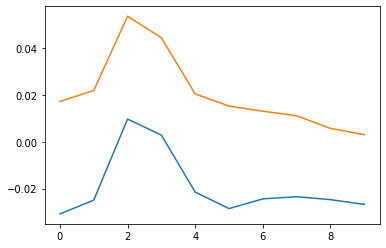

In [63]:
#### SCENARIOS FORECAST ####

ResimBand = ResSVAR.irf_errband_mc() #Tuple of lower and upper arrays of ma_rep monte carlo standard errors
Resim = ResSVAR.irf_resim()
print(ResimBand)

UpperBand = []
LowerBand = []

for i in range(1,11):
    UpperBand.append(ResimBand[0][i][1][4])
    LowerBand.append(ResimBand[1][i][1][4])


print("---------------------------")
print(UpperBand)

print("---------------------------")
print(LowerBand)

plt.plot(UpperBand)
plt.plot(LowerBand)
plt.show()


#find mean of the 2 bands ????

